Latent Dirichlet Allocation (LDA) is a popular form of statistical topic modeling. In LDA, documents are represented as a mixture of topics and a topic is a bunch of words. Those topics reside within a hidden, also known as a latent layer. 

LDA looks at a document to determine a set of topics that are likely to have generated that collection of words. So, if a document uses certain words that are contained in a topic, you could say the document is about that topic.

https://blog.marketmuse.com/glossary/latent-dirichlet-allocation-definition/

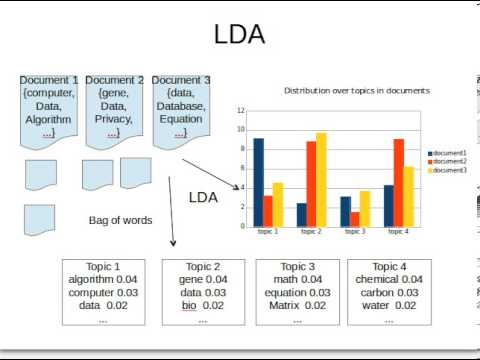

### LDA Intuition

At a high level the LDA model attempts to model two probability distributions given data that is "words present in documents".

1. The probability of a topic over words - $p(word|topic)$ - Each "Topic" is a probability distribution over the words in that topic - for example a topic about sports might have high likelihood words such as "basketball, referree, football".

2. The probability of a document over topics $p(topics|document)$ - Each document can be represented as a probability distribution over "topics" by using the words in the document and the distribution above - for example an article about Davidson beating Duke at basketball might have high likelihood over topics for sports and college.


The approach above makes this model very cool and flexible - providing "soft"/probabalistic membership of documents into many topics - and the choice of the Dirichlet distribution helps to make topics distinct from one another.
Additionally while it is "famous" for working on text - LDA is just an unsupervised learning algorithm that can be used for several downstream algorithms similar to most clustering or matrix factorization algorithms.
If you really want to go deep on the math we've linked the original paper by David Blei and team above.

<img src = "https://www.researchgate.net/publication/346801402/figure/fig1/AS:986776055345152@1612277153515/LDA-underlying-intuition-Generation-of-documents-through-topics-following-the-Dirichlet.png">



### Load dependencies and helper functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import math


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(math.ceil(len(model.components_)/5), 5, figsize=(20, 6*math.ceil(len(model.components_)/5)), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

def get_topic_names(model, feature_names, n_top_words):
    topic_names = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_features = [str(topic_idx+1)]+top_features
        topic_names.append("_".join(top_features))
    return topic_names

    

### We created a clean data set of articles, titles and most recent publish dates for this exercise - you can find the dataset here - 

In [2]:
data = pd.read_csv("./data/wp_posts2022-11-12 14:34:48.917154.csv")

In [3]:
# This article is updated weekly receiving a huge amount of sessions
# This is not the norm and therefore considered an outlier
# Removing so it does the topic with it does not get an advantage 
data = data[data.link != 'https://www.plateapr.com/que-hacer-este-fin-de-semana-en-puerto-rico/']

In [4]:
data.head(1)

,title,content,link,date,author,type
0,"4 cosas que debes saber de biciPOP, una nueva ...","4 cosas que debes saber de bicipop, una nueva ...",https://www.plateapr.com/4-cosas-que-debes-sab...,2022-11-11T15:33:57,13,post


In [5]:
ignore_titles = [
    
                '¿Qué es Platea?',
                 'Terms of Use', 
                 
                 
                 'Gobierno elimina de forma temporera el IVU en los alimentos preparados', 
                 '3 restaurantes que dan cátedra de recuperación tras Fiona',
                 '4 maneras de ayudar a las comunidades de la zona oeste tras el paso del huracán Fiona',
                 'Distrito T-Mobile servirá como centro de acopio para brindar ayuda a los damnificados por el huracán Fiona',
                 'Tu negocio podría recibir ayuda económica ante daños causados por el huracán Fiona',
                 'Restaurantes y coffee shops locales abiertos tras el paso de Fiona por la isla',
                 'Cancelación de eventos por el paso de la tormenta Fiona',
                ]
ignore_index = []
for index, row in data.iterrows():
    if row['title'] in ignore_titles:
        ignore_index.append(index)
    print(index, row['title'], row['link'])
                            
    

0 4 cosas que debes saber de biciPOP, una nueva bicicleta eléctrica para transporte en la isla https://www.plateapr.com/4-cosas-que-debes-saber-de-bicipop-una-nueva-bicicleta-electrica-para-transporte-en-la-isla/
2 Más de 30 barras se unen a Puerto Rico Cocktail Week para servir cócteles únicos y budget friendly https://www.plateapr.com/mas-de-30-barras-se-unen-a-puerto-rico-cocktail-week-para-servir-cocteles-unicos-y-a-costos-reducidos/
3 Dueños de Airbnb en Puerto Rico podrán instalar sensores de ruido para evitar que hagas fiestas https://www.plateapr.com/duenos-de-airbnb-en-puerto-rico-podran-instalar-sensores-de-ruido-para-evitar-que-hagas-fiestas/
4 5 barras para ir de tapas en noviembre https://www.plateapr.com/3-barras-para-ir-de-tapas-en-noviembre/
5 12 lugares para hacer catering durante Acción de Gracias https://www.plateapr.com/lugares-con-servicio-de-catering-para-actividades/
6 7 restaurantes abiertos los lunes en el área metro https://www.plateapr.com/restaurantes-abiert

In [6]:
ignore_index

[21, 22, 23, 24, 25, 26, 28, 97, 127]

In [7]:
data.iloc[ignore_index]

,title,content,link,date,author,type
22,4 maneras de ayudar a las comunidades de la zo...,4 maneras de ayudar a las comunidades de la zo...,https://www.plateapr.com/4-maneras-ayudar-la-z...,2022-09-29T16:40:57,13,post
23,Distrito T-Mobile servirá como centro de acopi...,distrito t mobile servirá como centro de acopi...,https://www.plateapr.com/distrito-t-mobile-ser...,2022-09-23T11:17:23,13,post
24,Tu negocio podría recibir ayuda económica ante...,tu negocio podría recibir ayuda económica ante...,https://www.plateapr.com/tu-negocio-podria-rec...,2022-09-21T13:47:38,13,post
25,Gobierno elimina de forma temporera el IVU en ...,gobierno elimina de forma temporera el ivu en ...,https://www.plateapr.com/elimina-ivu-en-los-al...,2022-09-19T21:25:36,34,post
26,Restaurantes y coffee shops locales abiertos t...,comida y coffee shops locales abiertos tras el...,https://www.plateapr.com/restaurantes-y-coffee...,2022-09-19T11:48:52,34,post
27,Nueve panaderías artesanales alrededor de la i...,nueve panaderías artesanales alrededor de la i...,https://www.plateapr.com/panaderias-artesanales/,2022-09-16T01:20:00,5,post
29,Volverán a elevar el globo de Jayuya,volverán a elevar el globo de jayuya la indust...,https://www.plateapr.com/el-globo-de-jayuya/,2022-09-14T17:24:43,34,post
98,Tu guía de cinco actividades para hacer en Las...,tu guía de cinco actividades para hacer en las...,https://www.plateapr.com/guia-actividades-en-l...,2022-03-02T11:27:36,13,post
128,Lugares para alquilar un catamarán en Puerto Rico,lugares para alquilar un catamarán en puerto r...,https://www.plateapr.com/lugares-para-alquilar...,2021-10-22T17:27:03,13,post


In [8]:
data=data.drop(index=ignore_index).reset_index()

In [9]:
data.shape

(189, 7)

In [10]:
texts = data.content

### Vectorizing Text

First, we're going to turn our original unstructured data (raw text) into a form usable by ML models.

The technique we are going to use to turn our text data into a numeric matrix is called "bag of words" - 
- 1 document = 1 row
- 1 word in our vocabulary = 1 column
- each entry = count of occurences of that word (column) in that document (row)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

In [11]:
places_tags = ['restaurantes',
 'ocean-park',
 'aire-libre',
 'fine-dining',
 'deportes',
 'hospedajes',
 'boutique-hotels',
 'comida-italiana',
 'cocteles',
 'hiking',
 'cuevas',
 'clases-y-workshops',
 'bakery',
 'wi-fi',
 'aventura',
 'drinks',
 'entretenimiento',
 'panaderias',
 'coffee-shops',
 'bed-amp-breakfast',
 'dinner',
 'tapas',
 'arte-y-cultura',
 'hidden-gem',
 'seafood',
 'comida-del-medio-oriente',
 'ecoturismo',
 'adventure',
 'turismo-interno',
 'mariscos',
 'familiar',
 'comida-internacional',
 'comida-americana',
 'opciones-vegetarianas-y-veganas',
 'airbnb',
 'budget-friendly',
 'food-truck',
 'reposteria',
 'brewery',
 'musica-en-vivo',
 'tours',
 'area-metro',
 'playas',
 'barras',
 'nightlife',
 'eventos',
 'parques-y-reservas',
 'shopping',
 'outdoor-dining',
 'speakeasy',
 'plaza-publica',
 'comida-vegetariana-y-vegana',
 'things-to-do',
 'comida-criolla',
 'juegos-y-diversion',
 'parking',
 'chinchorro',
 'casual-dining',
 'comida-fusion',
 'family-friendly',
 'parques',
 'museos',
 'comida-mexicana',
 'gratis',
 'pizzeria',
 'heladerias',
 'comida-asiatica',
 'mountain-bike',
 'pet-friendly',
 'rooftop',
 'postres',
 'adjuntas',
 'brunch']

places_tags = [s.split('-') for s in places_tags]



tags = []
for t in places_tags:
    if isinstance(t, list):
        tags = tags + t
    else:
        tags.append(t)
        
        
tags = ['parking']

In [12]:
# Stop Words in spanish from: https://github.com/Alir3z4/stop-words/blob/master/spanish.txt
# In addition to those we added the stop words for english since we do have some spanglish on the blogs

stop_words = []

with open("./data/stop_words.txt", "r") as file:
    stop_words = file.readlines()
stop_words = [s.strip().lower() for s in stop_words]
stop_words = stop_words + tags
stop_words[len(stop_words)-10: len(stop_words)-1]

['that', 'we', 'this', 'on', 'other', 'under', 'use', 'promotions', '']

In [13]:
#define our vectorizer class


# We also tried the Tfid vectorizer but it would group all of them in one topic
#tf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words=stop_words, ngram_range=(1,2))
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words=stop_words, ngram_range=(1,2))


In [14]:
#fit the vectorizer to our text data and apply the transformation
tf = tf_vectorizer.fit_transform(texts)

In [15]:
# Each document is now a 1x10000 matrix as described above, and we have 10000 documents
print("Shape =",tf.shape)

Shape = (189, 10000)


In [16]:
#'tf_vectorizer.vocabulary_' this is our "vocabulary" that we inferred from the text 
#each word token we extracted and the count of that word token across the corpus
pd.DataFrame.from_dict(tf_vectorizer.vocabulary_,orient = "index").head(30)

,0
debes,3761
bicicleta,1760
transporte,9231
isla,5452
empresa,4490
alquiler,1036
bicicletas,1761
opciones,6447
alternativo,1052
sistema,8623


### Set up the LDA Model

Similar to many clustering techniques, one of the main inputs to LDA is the number of topics - `n_components`.

There are other related techniques that try to infer the number of topics from the data itself such as hierarchical LDA - but the "base" model requires that input.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [17]:
n_components = 5
n_top_words = 20

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    random_state=0,
    verbose = 2 # this could take a little bit, so we specify higher verbosity for some logs
)

##### Fit our LDA model and store the topic distributions for each document in `clusters`

In [18]:
clusters = lda.fit_transform(tf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


### Now, we can visualize our topics

You can try playing around with different params and see what results you get.

The main things to tune are:
1. The number of topics - `n_components`
2. The parameters of the CountVectorizer - which basically play with how many words you would extract from the text and some logic on top of that, and therefore how many/what type of columns you have in your vectorized matrix.

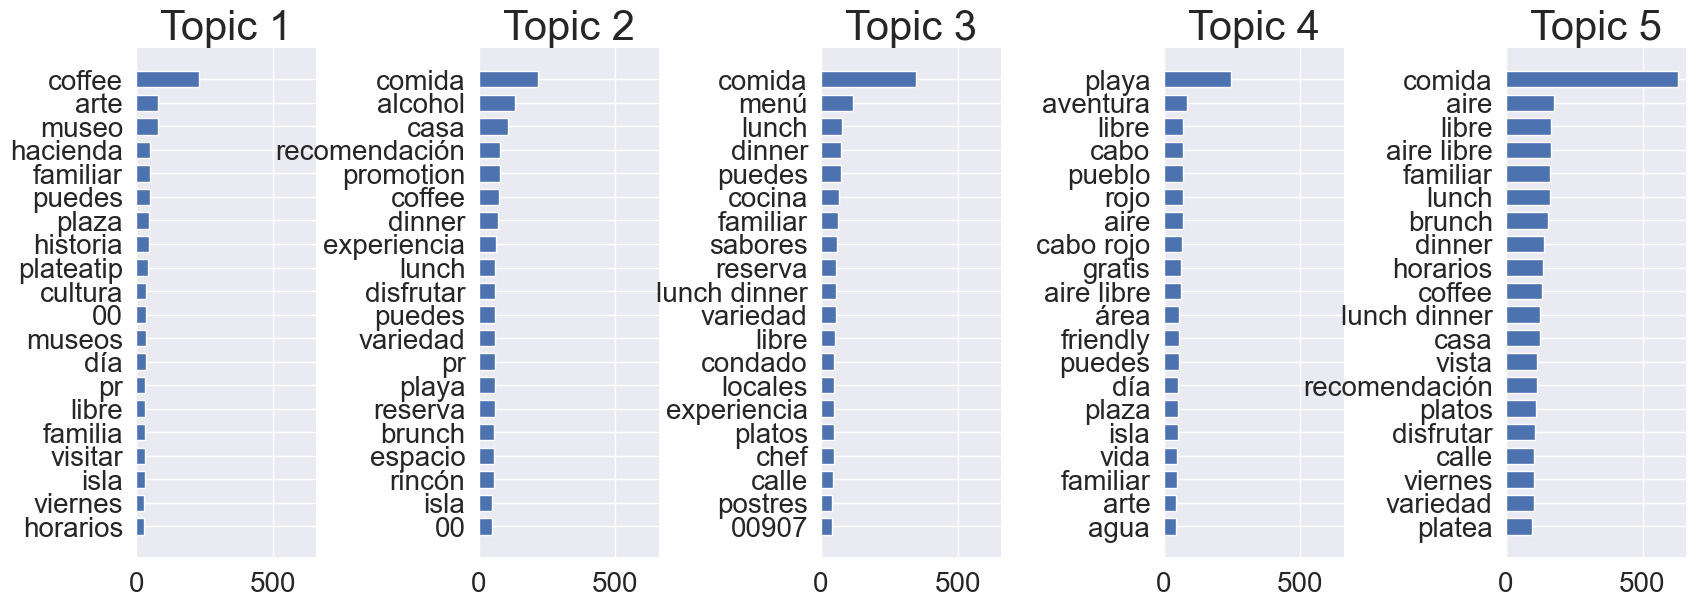

In [19]:
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "")

In [20]:
len(tf_feature_names)

10000

### We can also visualize the topic distribution of a particular article - because of how the LDA model works

The code below will take a random sample article and visualize the topic distribution of that text

In [21]:
#get topic "names" - by taking the 4 most likely word tokens in the topic
topic_names = get_topic_names(lda, feature_names=tf_feature_names, n_top_words=4)

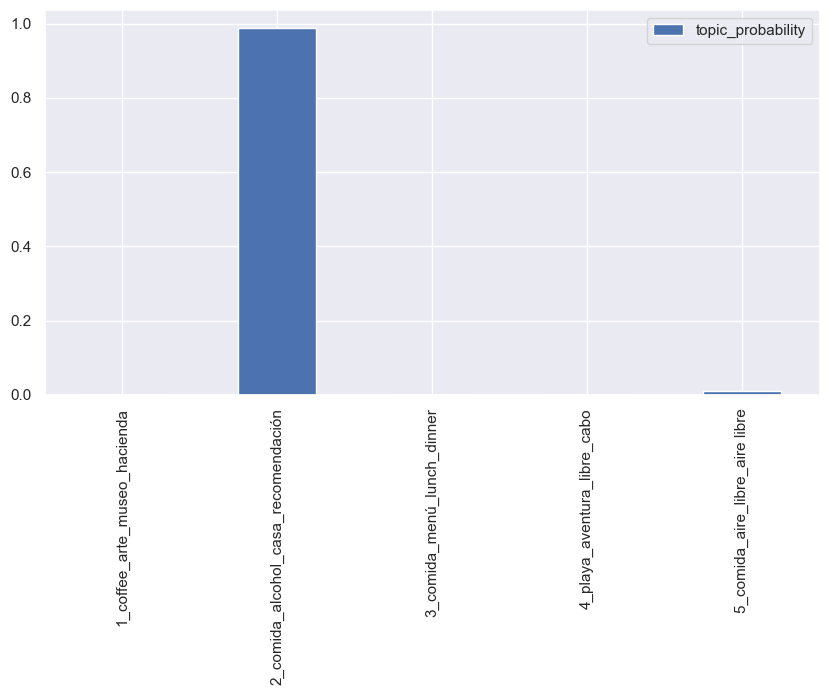

In [22]:
pd.DataFrame(index= topic_names, data= clusters[np.random.choice(len(texts))], columns = ["topic_probability"]).plot.bar(figsize = (10,5), rot=90)
plt.show()

In [23]:
titles = data.title
topics = []
for i in range(len(data)):
    probs = pd.DataFrame(index= topic_names, data= clusters[i], columns = ["topic_probability"])
    # print(titles[i], ": ",probs[probs.topic_probability ==  max(probs.topic_probability)].index.values[0])
    topics.append(probs[probs.topic_probability ==  max(probs.topic_probability)].index.values[0]) 


In [24]:
data['topic']=topics  

In [25]:
# Counting number of posts by topic
counts = data['topic'].value_counts().reset_index()
counts = counts.rename(columns={"topic": "count", "index":"topic"})
counts

,topic,count
0,5_comida_aire_libre_aire libre,54
1,2_comida_alcohol_casa_recomendación,41
2,4_playa_aventura_libre_cabo,34
3,3_comida_menú_lunch_dinner,32
4,1_coffee_arte_museo_hacienda,28


In [26]:
# Lets look into how many articles we have pr topic

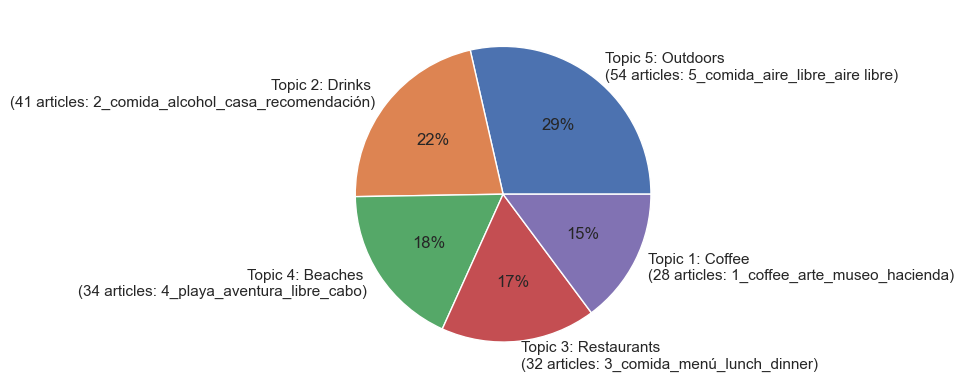

In [27]:

labels = []
broader_names = ['Coffee', 'Drinks', 'Restaurants', 'Beaches', 'Outdoors'] #Identified broader names based on the words


topic_described = {}
for value, topic in zip(counts['count'].values, counts.topic.values):
    index = int(topic[0])
    
    labels.append(f'Topic {index}: {broader_names[index-1]} \n({value} articles: {topic})')
    topic_described[topic] = f'Topic {index}: {broader_names[index-1]} \n({value} articles)'

plt.pie(counts['count'].values, labels = labels, autopct='%.0f%%')
plt.show()

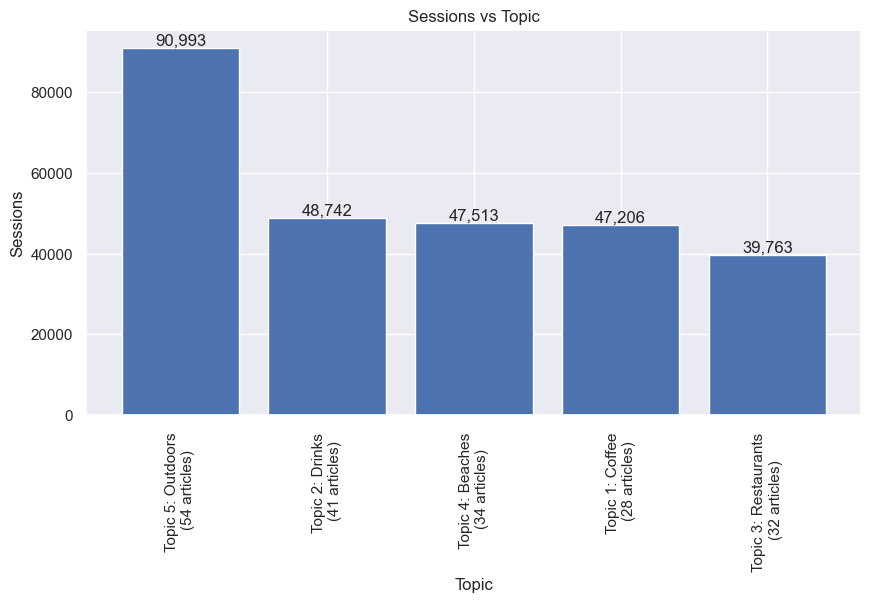

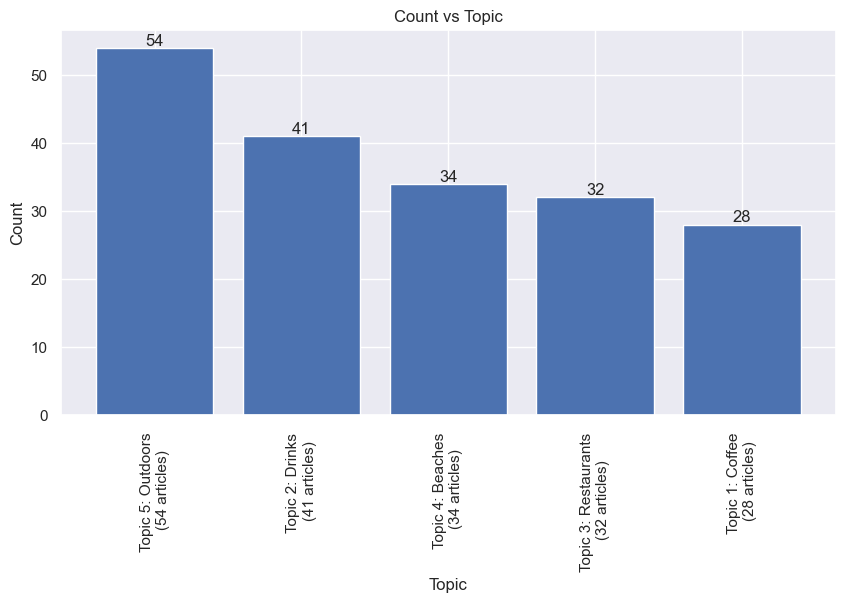

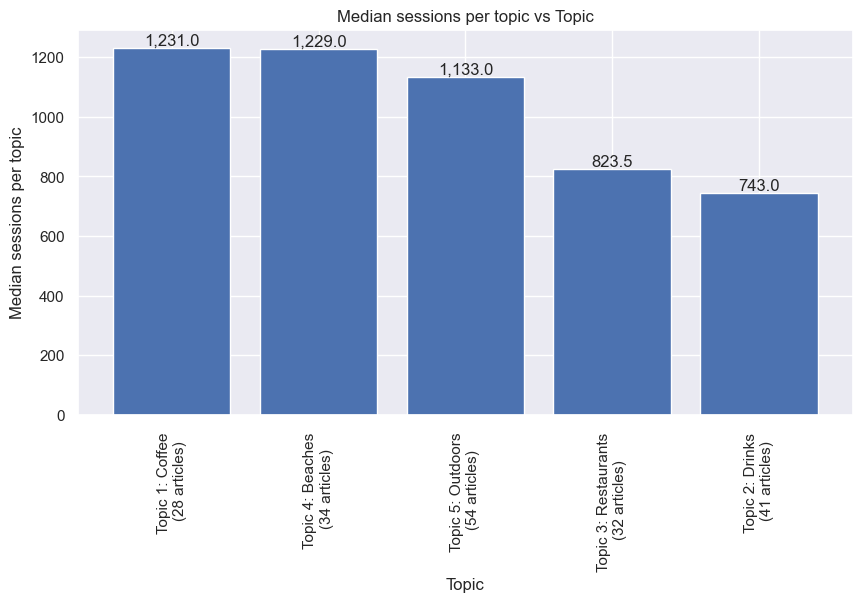

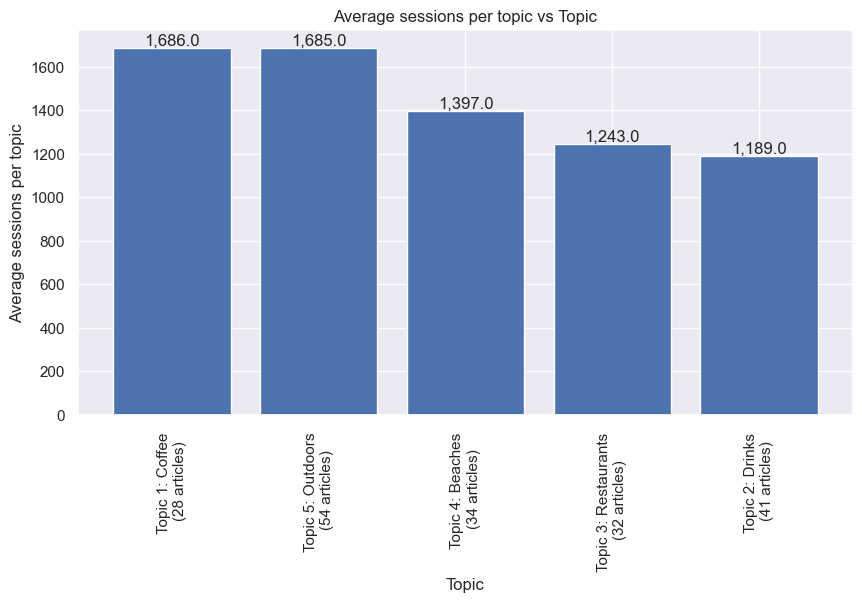

In [28]:
# Aggregating sessions by topics
import statistics


counts = data['topic'].value_counts().reset_index()
counts = counts.rename(columns={"topic": "count", "index":"topic"})


combined = pd.merge(data,  pd.read_csv("./data/sessions_2022-11-13 12:54:45.198118.csv"), how='inner', left_on = 'link', right_on = 'url_clean')

medians = combined.groupby('topic').agg({'sessions': 'median'}).reset_index()
medians= medians.rename(columns={"sessions": "Median sessions per topic"})
by_topic = combined.groupby('topic').agg({'sessions': 'sum'}).reset_index()


by_topic = pd.merge(by_topic, counts, how='inner', left_on = 'topic', right_on = 'topic')
by_topic = pd.merge(by_topic, medians, how='inner', left_on = 'topic', right_on = 'topic')




by_topic['Average sessions per topic'] = round(by_topic['sessions']/by_topic['count'],0)
# by_topic['Median per topic'] = 
by_topic['topic_described'] = [topic_described[topic] for topic in by_topic['topic']]

y_values = [c for c in by_topic.columns if (c != 'topic' and  c != 'topic_described')]
for c in y_values:
    sorted_df = by_topic.sort_values(by=[c], ascending=False)
    figure = plt.figure('myfigureid', figsize = (10,5))
    axis = figure.add_subplot(1,1,1)
    axis.bar(sorted_df['topic_described'], sorted_df[c])
    
    rects = axis.patches

    # Make some labels.

    for rect, label in zip(rects, sorted_df[c]):
        height = rect.get_height()
        axis.text(
            rect.get_x() + rect.get_width() / 2, height, "{:,}".format(label), ha="center", va="bottom"
        )

    axis.set_ylabel(c.capitalize())
    axis.set_xlabel('topic'.capitalize())
    axis.set_title(f"{c.capitalize()} vs Topic")
    plt.xticks(rotation = 90)
    plt.show()

In [29]:
combined['topic_described'] = [topic_described[c] for c in combined['topic']]

In [30]:
sessions_std = combined.describe()['sessions']['std']

In [31]:
cleaned = combined[ combined['sessions'] < 2 * sessions_std]
cleaned = combined

Text(0.5, 25.000000000000014, 'Topic')

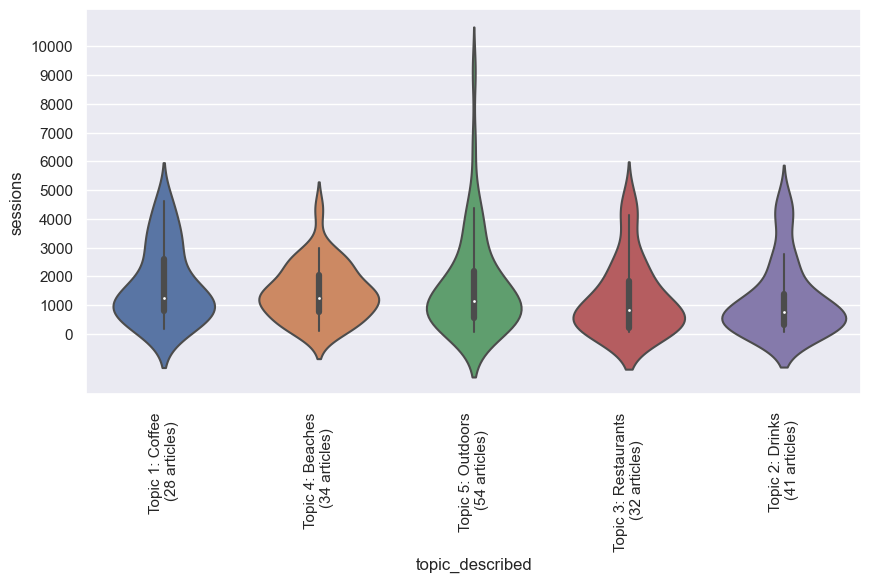

In [32]:
plt.figure('violin', figsize = (10,5))
plt.xticks(rotation = 90)
plt.yticks(np.arange(0, max(cleaned["sessions"].values)+1000, 1000))
sns.violinplot( y=cleaned["sessions"], x=cleaned['topic_described'], order=cleaned.groupby(by=["topic_described"])["sessions"].median().sort_values(ascending=False).index)
axis.set_ylabel('sessions'.capitalize())
axis.set_xlabel('topic'.capitalize())

<AxesSubplot:xlabel='topic_described', ylabel='sessions'>

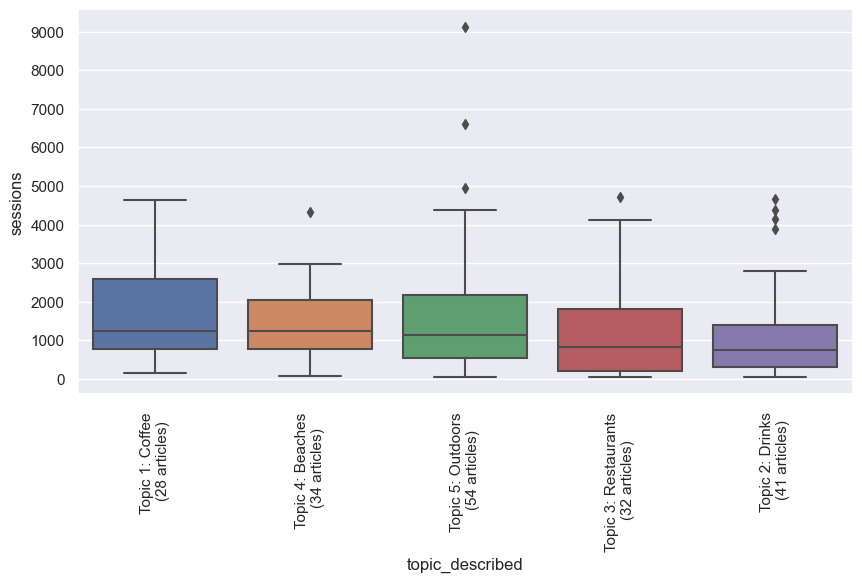

In [33]:
plt.figure('violin', figsize = (10,5))
plt.yticks(np.arange(0, max(combined["sessions"].values)+2000, 1000))
plt.xticks(rotation = 90)
order= cleaned.groupby(by=["topic_described"])["sessions"].median().index
sns.boxplot( y=cleaned["sessions"], x=cleaned["topic_described"], order=cleaned.groupby(by=["topic_described"])["sessions"].median().sort_values(ascending=False).index)


In [210]:
# See the titles on each topic to get an idea
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

for topic in counts['topic'].values:
    print(topic_described[topic], topic)
    
    curr_topic = combined[combined.topic ==topic].sort_values(by=['sessions'], ascending=False)
    print(curr_topic[['title', 'sessions', 'link']])
    print('\n')

/var/folders/zj/qbh81wyd36s5xgr4pxwy71k80000gq/T/ipykernel_30417/1214708225.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


Topic 5: Outdoors 
(54 articles) 5_comida_aire_libre_aire libre
                                                                             title  sessions                                                                                    link
148  6 restaurantes con vista a las montañas                                        9121      https://www.plateapr.com/restaurantes-con-vista-a-las-montanas/                       
91   Ocho restaurantes que son hidden gems y no te debes perder                     6609      https://www.plateapr.com/restaurantes-hidden-gems/                                    
111  Ocho lugares para celebrar tu boda                                             4940      https://www.plateapr.com/lugares-para-celebrar-tu-boda/                               
33   Spots en el oeste para ver la puesta del sol                                   4375      https://www.plateapr.com/spots-para-ver-el-atardecer/                                 
183  Lugares pet-friendly para 

In [211]:
# See the titles on each topic to get an idea

for topic in counts['topic'].values:
    print(topic)
    for title in combined[combined.topic ==topic]['title'].values:
        print(f'\t\t{title}')
    print('\n')

5_comida_aire_libre_aire libre
		7 restaurantes abiertos los lunes en el área metro
		10 actividades para aprovechar el fin de semana lluvioso
		Ruta por Lares: Qué hacer y dónde comer
		8 terrazas únicas donde puedes tomarte un buen café
		Coffee shops para coffee lovers en San Juan
		Ocho barras con vista al mar para visitar en Puerto Rico
		Kioskos en Piñones para matar los munchies después de la playa
		Join a Join y Airbnb&#8217;s con piscina disponibles este fin de semana largo
		Spots en el oeste para ver la puesta del sol
		7 Airbnbs en el Viejo San Juan por menos de $150 la noche
		Los mejores Airbnb&#8217;s en Puerto Rico por menos de $100 la noche
		De roadtrip por Trujillo Alto en busca de historia, cultura y helados veganos
		Seis brunch spots en el Viejo San Juan para visitar este wikén
		Seis heladerías pet-friendly para sobrevivir el calor del verano en familia
		6 Airbnbs cerca de la playa para grupos pequeños o familias
		5 Restaurantes en el centro de Mayagüez que ti

In [212]:
combined.groupby('link').agg({'sessions': 'sum', 'views':'sum', 'return_visitors':'sum'}).reset_index().sort_values(by=['sessions'], ascending=False)[0:30].groupby('link').agg({'sessions': 'sum', 'views':'sum', 'return_visitors':'sum'}).reset_index().sort_values(by=['sessions'], ascending=False)[0:30]

,link,sessions,views,return_visitors
21,https://www.plateapr.com/restaurantes-con-vista-a-las-montanas/,9121,15388,2319
25,https://www.plateapr.com/restaurantes-hidden-gems/,6609,17490,1810
12,https://www.plateapr.com/lugares-para-celebrar-tu-boda/,4940,7374,741
10,https://www.plateapr.com/lugares-con-servicio-de-catering-para-actividades/,4706,6373,1461
1,https://www.plateapr.com/alquileres-vacacionales-con-piscinas-privadas-en-puerto-rico/,4662,6596,859
29,https://www.plateapr.com/ver-el-live-del-concierto-de-bad-bunny/,4624,10283,745
8,https://www.plateapr.com/librerias-locales-en-puerto-rico/,4388,8184,965
23,https://www.plateapr.com/restaurantes-en-caguas/,4378,6685,1260
28,https://www.plateapr.com/spots-para-ver-el-atardecer/,4375,7249,1370
19,https://www.plateapr.com/playas-escondidas-en-puerto-rico/,4336,10603,1277
